# Computer Vision, Assignment 3: Epipolar Geometry

In this assignment, you will study epipolar geometry. 
You will use the fundamental matrix and the essential matrix for simultaneously reconstructing the 3D structure and the camera motion from two images.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are ``mandatory'' in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).

In [5]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io

from supplied import pflat, plot_camera, rital

# The Fundamental Matrix

#### *Theoretical exercises 1-4* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/kronan1.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/kronan2.JPG" width="250px">
    <figcaption>Figure1. kronan1.jpg and kronan2.jpg</figcaption>
</figure>

In this exercise you will compute the fundamental matrix for the two images above, showing a part of the fort Kronan in Gothenburg. The calibration matrix $K$ is assumed to be unknown. The file `compEx1data.mat` contains a cell `x` with matched points for the two images.

### Task 1.1
Compute normalization matrices $N_1$ and $N_2$. These matrices should subtract the mean and re-scale using the standard deviation, as in assignment 2.
Normalize the image points of the two images with $N_1$ and $N_2$, respectively.

In [2]:
import numpy as np
from scipy.io import loadmat

data = loadmat("data/compEx1data.mat")

if "x" in data:
    Xcell = data["x"]
elif "X" in data:
    Xcell = data["X"]
else:
    raise KeyError(f"Hittar varken 'x' eller 'X'. Keys är: {list(data.keys())}")

flat = Xcell.ravel()
x1 = np.array(flat[0], dtype=float)
x2 = np.array(flat[1], dtype=float)

if x1.shape[0] == 2:
    x1 = np.vstack([x1, np.ones((1, x1.shape[1]))])
if x2.shape[0] == 2:
    x2 = np.vstack([x2, np.ones((1, x2.shape[1]))])

def normalization_matrix(x):
    mu = np.mean(x[:2, :], axis=1)
    sig = np.std(x[:2, :], axis=1)
    sig[sig == 0] = 1.0  

    N = np.array([
        [1.0/sig[0], 0.0, -mu[0]/sig[0]],
        [0.0, 1.0/sig[1], -mu[1]/sig[1]],
        [0.0, 0.0, 1.0]
    ])
    return N

N1 = normalization_matrix(x1)
N2 = normalization_matrix(x2)

x1n = N1 @ x1
x2n = N2 @ x2

print("N1=\n", N1)
print("N2=\n", N2)
print("mean/std img1:", np.mean(x1n[:2,:], axis=1), np.std(x1n[:2,:], axis=1))
print("mean/std img2:", np.mean(x2n[:2,:], axis=1), np.std(x2n[:2,:], axis=1))


N1=
 [[ 0.00238     0.         -2.02599909]
 [ 0.          0.00300312 -2.00511271]
 [ 0.          0.          1.        ]]
N2=
 [[ 0.00220246  0.         -1.67486982]
 [ 0.          0.00288869 -1.91860117]
 [ 0.          0.          1.        ]]
mean/std img1: [ 3.09977807e-15 -8.77562741e-16] [1. 1.]
mean/std img2: [-1.00495088e-15  1.71266277e-15] [1. 1.]


### Task 1.2
Set up the matrix $M$ in the eight point algorithm (8 is the minimum number of points, you should use all the points here), and solve the homogeneous least squares system using SVD. 
Check that the minimum singular value and $||Mv||$ are both small. Construct the $3 \times 3$ matrix $\tilde F$ from the solution $v$. This matrix should approximately satisfy $\tilde x_2^T \tilde F \tilde x_1 = 0$, where $\tilde x_j$ are normalized image points. Write the code as a function which would be useful later. 

In [ ]:
def estimate_F_DLT(x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    '''
    # Your code here
    x1 = x1s[0, :] / x1s[2, :]
    y1 = x1s[1, :] / x1s[2, :]
    x2 = x2s[0, :] / x2s[2, :]
    y2 = x2s[1, :] / x2s[2, :]

    N = x1s.shape[1]
    M = np.zeros((N, 9))

    M[:, 0] = x2 * x1
    M[:, 1] = x2 * y1
    M[:, 2] = x2
    M[:, 3] = y2 * x1
    M[:, 4] = y2 * y1
    M[:, 5] = y2
    M[:, 6] = x1
    M[:, 7] = y1
    M[:, 8] = 1.0

    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1, :]              
    F = v.reshape(3, 3)        

    smin = S[-1]
    res = np.linalg.norm(M @ v)

    return F, M, smin, res



min singular value: 0.04965450019510637
||M v||: 0.04965450019510683
mean |x2^T F x1|: 0.0006748716490117983
max  |x2^T F x1|: 0.008308983625197053


You must also make sure that $\det(\tilde{F}) = 0$ for your solution. Make a separate function that explicitly enforces the constraint, as this will be convenient for you later.

In [51]:
def enforce_fundamental(F_approx):
    '''
    F_approx - Approximate Fundamental matrix (3x3)
    '''
    # Your code here
    U, S, Vt = np.linalg.svd(F_approx)

    S[-1] = 0.0

    F = U @ np.diag(S) @ Vt
    return F



Estimate $\tilde{F}$ and check that the epipolar constraints $\tilde{x}_2^T \tilde{F} \tilde{x}_1 = 0$ are roughly fulfilled.


In [66]:
# ------ Your code here ------

# Estimate F_tilde 
F_tilde_approx, M, smin, res = estimate_F_DLT(x1n, x2n)
F_tilde = enforce_fundamental(F_tilde_approx)

print("min singular value of M:", smin)
print("||M v||:", res)
print("det(F_tilde):", np.linalg.det(F_tilde))

# Check epipolar constraints
vals = np.sum(x2n * (F_tilde @ x1n), axis=0)   
print("mean |x2^T F x1|:", np.mean(np.abs(vals)))
print("max  |x2^T F x1|:", np.max(np.abs(vals)))
print("RMS  |x2^T F x1|:", np.sqrt(np.mean(vals**2)))


min singular value of M: 0.04965450019510637
||M v||: 0.04965450019510683
det(F_tilde): 1.1651056220841274e-18
mean |x2^T F x1|: 0.0007158981329757655
max  |x2^T F x1|: 0.007951132480184142
RMS  |x2^T F x1|: 0.0011470700383712134


### Task 1.3



Compute the un-normalized fundamental matrix $F$ (using the formula from exercise 4) and the epipolar lines $l = F x_1$. Pick 20 points in the second image at random and plot these in the same figure as the image.
Also plot the corresponding epipolar lines in the same image using the function `rital`. Verify that the points are close to the corresponding epipolar lines.





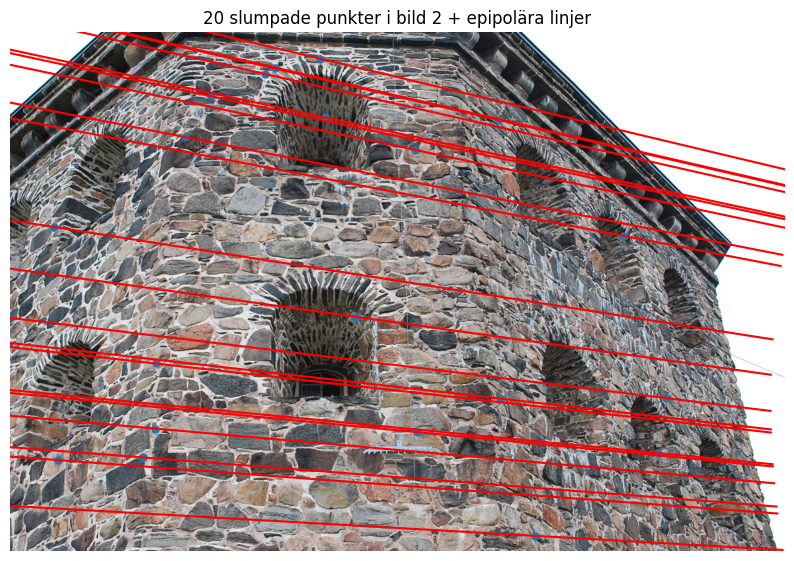

min singular value(M): 0.04965450019510637
||M v||: 0.04965450019510683
det(F_tilde): 1.1651056220841274e-18
mean dist: 0.37747549999676683
max  dist: 1.1874823882422836


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from supplied import rital
data = loadmat("data/compEx1data.mat")
if "x" in data:
    Xcell = data["x"]
else:
    Xcell = data["X"]

flat = Xcell.ravel()
x1 = np.array(flat[0], dtype=float)
x2 = np.array(flat[1], dtype=float)


if x1.shape[0] == 2:
    x1 = np.vstack([x1, np.ones((1, x1.shape[1]))])
if x2.shape[0] == 2:
    x2 = np.vstack([x2, np.ones((1, x2.shape[1]))])

def make_N(x):
    mu = np.mean(x[:2, :], axis=1)
    sig = np.std(x[:2, :], axis=1)
    sig[sig == 0] = 1.0
    return np.array([
        [1.0/sig[0], 0.0, -mu[0]/sig[0]],
        [0.0, 1.0/sig[1], -mu[1]/sig[1]],
        [0.0, 0.0, 1.0]
    ])

N1 = make_N(x1)
N2 = make_N(x2)

x1n = N1 @ x1
x2n = N2 @ x2

def estimate_F_DLT(x1s, x2s):
    x1 = x1s[0, :] / x1s[2, :]
    y1 = x1s[1, :] / x1s[2, :]
    x2 = x2s[0, :] / x2s[2, :]
    y2 = x2s[1, :] / x2s[2, :]

    N = x1s.shape[1]
    M = np.zeros((N, 9))
    M[:, 0] = x2 * x1
    M[:, 1] = x2 * y1
    M[:, 2] = x2
    M[:, 3] = y2 * x1
    M[:, 4] = y2 * y1
    M[:, 5] = y2
    M[:, 6] = x1
    M[:, 7] = y1
    M[:, 8] = 1.0

    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1, :]
    F = v.reshape(3, 3)
    return F, M, S[-1], np.linalg.norm(M @ v)

def enforce_fundamental(F_approx):
    U, S, Vt = np.linalg.svd(F_approx)
    S[-1] = 0.0
    return U @ np.diag(S) @ Vt

F_tilde_approx, M, smin, res = estimate_F_DLT(x1n, x2n)
F_tilde = enforce_fundamental(F_tilde_approx)

F = N2.T @ F_tilde @ N1
F = F / np.linalg.norm(F)

l2 = F @ x1  

rng = np.random.default_rng(0)
N = x2.shape[1]
idx = rng.choice(N, size=min(20, N), replace=False)

I2 = plt.imread("data/kronan2.JPG")
plt.figure(figsize=(10, 7))
plt.imshow(I2)

x_plot = x2[0, idx] / x2[2, idx]
y_plot = x2[1, idx] / x2[2, idx]
plt.scatter(x_plot, y_plot, s=25)

rital(l2[:, idx].T, 'r')

plt.title("20 slumpade punkter i bild 2 och epipolära linjer")
plt.axis("off")
plt.show()

a = l2[0, idx]; b = l2[1, idx]; c = l2[2, idx]
dist = np.abs(a*x_plot + b*y_plot + c) / np.sqrt(a*a + b*b)
print("min singular value(M):", smin)
print("||M v||:", res)
print("det(F_tilde):", np.linalg.det(F_tilde))
print("mean dist:", np.mean(dist))
print("max  dist:", np.max(dist))


Compute the distance between all the points and their corresponding epipolar lines and plot these in a histogram with 100 bins.
What is the mean distance? Create a function as this would be useful later.

In [16]:
def compute_epipolar_errors(F, x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    F - Fundamental matrix (3x3)
    '''
    # Your code here
    l2 = F @ x1s  

    x = x2s[0, :] / x2s[2, :]
    y = x2s[1, :] / x2s[2, :]

    a = l2[0, :]
    b = l2[1, :]
    c = l2[2, :]

    d = np.abs(a*x + b*y + c) / np.sqrt(a*a + b*b)
    return d


mean distance: 0.36123310274798515


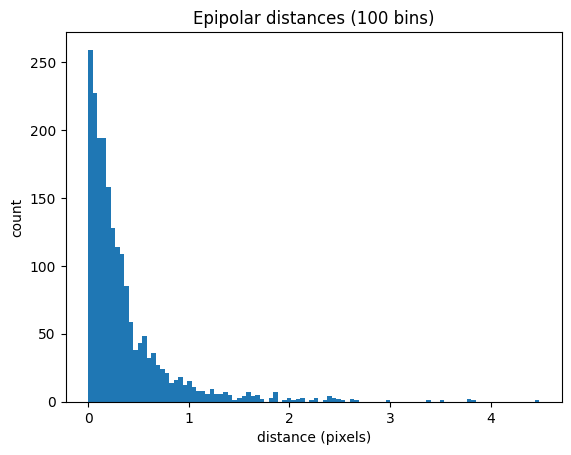

In [17]:
# ------ Your code here ------

# Compute mean epipolar distance
dists = compute_epipolar_errors(F, x1, x2)
mean_dist = np.mean(dists)
print("mean distance:", mean_dist)
# Plot epipolar distances in a histogram
plt.figure()
plt.hist(dists, bins=100)
plt.title("Epipolar distances (100 bins)")
plt.xlabel("distance (pixels)")
plt.ylabel("count")
plt.show()

#### Your answer here: 

The mean distance with normalization is: 0.36123310274798515

### Task 1.4

See what happens if we do everything without normalization (that is, set $N_1=N_2=I$ and run the code again).
What is the mean distance in this case?

In [28]:
# ------ Your code here ------

# See what happens if N1=N2=I
N1_I = np.eye(3)
N2_I = np.eye(3)

x1_I = N1_I @ x1
x2_I = N2_I @ x2

F_approx_I, M_I, smin_I, res_I = estimate_F_DLT(x1_I, x2_I)
F_I = enforce_fundamental(F_approx_I)

# Compute mean epipolar distance for this case
dists_I = compute_epipolar_errors(F_I, x1, x2)
mean_dist_I = np.mean(dists_I)

print("min singular value(M):", smin_I)
print("||M v||:", res_I)
print("mean distance without normalization:", mean_dist_I)


min singular value(M): 0.56293477675392
||M v||: 0.5629347767539089
mean distance without normalization: 0.4878403580862656


#### Your answer here: 

The mean distance without normalization is: 0.4878403580862656


#### *Theoretical exercise 5* (see pdf)

# The Essential Matrix

#### *Theoretical exercise 6* (see pdf)

## Computer Exercise 2


### Task 2.1

The file `compEx2data.mat` contains the calibration matrix $K$ for the two images in Computer Exercise 1. 
Normalize the image points using the inverse of $K$.

Set up the matrix $M$ in the eight point algorithm, and solve the homogeneous least squares system using SVD. Check that the minimum singular value and $Mv$ are both small. You can of course re-use function `estimate_F_DLT`.

Construct the essential matrix from the solution $v$. Don't forget to make sure that $E$ has two equal singular values and the third one zero.
As the essential matrix is a homogeneous entity, scale does not matter, but for grading purposes, please also make sure that the two non-zero singular values are both equal to 1.
Check that the epipolar constraints $\tilde{x}_2^T E\tilde{x}_1 = 0$ are roughly fulfilled.

In [38]:
def enforce_essential(E_approx):
    '''
    E_approx - Approximate Essential matrix (3x3)
    '''
    # Your code here
    U, S, Vt = np.linalg.svd(E_approx)
    E = U @ np.diag([1.0, 1.0, 0.0]) @ Vt
    return E


In [40]:
# ------ Your code here ------
# ------ Your code here ------

# Normalize the image points

d2 = loadmat("data/compEx2data.mat")
if "K" in d2:
    K = d2["K"]
    if isinstance(K, np.ndarray) and K.dtype == object:
        kflat = K.ravel()
        K1 = np.array(kflat[0], dtype=float)
        K2 = np.array(kflat[1], dtype=float) if kflat.size > 1 else K1.copy()
    else:
        K1 = np.array(K, dtype=float)
        K2 = K1.copy()
elif "K1" in d2 and "K2" in d2:
    K1 = np.array(d2["K1"], dtype=float)
    K2 = np.array(d2["K2"], dtype=float)
else:
    raise KeyError(f"No K found. Keys: {list(d2.keys())}")

x1c = np.linalg.inv(K1) @ x1
x2c = np.linalg.inv(K2) @ x2


# Set up the matrix M in eight point algorithm and solve for v

E_approx, M, smin, res = estimate_F_DLT(x1c, x2c)


# Check that minimum singular value and Mv both are small

print("min singular value(M):", smin)
print("||M v||:", res)


# Construct essential matrix from v (Ensuring that the two non-zero singular values are both equal to 1

E = enforce_essential(E_approx)
print("singular values of E:", np.linalg.svd(E, compute_uv=False))


# Check that epipolar constraints are roughly fulfilled

vals = np.sum(x2c * (E @ x1c), axis=0)
print("mean |x2^T E x1|:", np.mean(np.abs(vals)))
print("max  |x2^T E x1|:", np.max(np.abs(vals)))
print("RMS  |x2^T E x1|:", np.sqrt(np.mean(vals**2)))


min singular value(M): 0.006626799894543224
||M v||: 0.006626799894543129
singular values of E: [1.00000000e+00 1.00000000e+00 1.08239162e-16]
mean |x2^T E x1|: 0.0008038774006364328
max  |x2^T E x1|: 0.002587497776276565
RMS  |x2^T E x1|: 0.0009328292506660226


### Task 2.2

Compute the fundamental matrix for the un-normalized coordinate system from the essential matrix and compute the epipolar lines $l = F  x_1$. Pick 20 of the detected points in the second image
at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same figure using the function `rital`.

Compute the distance between the points and their corresponding epipolar lines and plot these in a histogram with 100 bins. 
**How does this result compare to the corresponding result in Computer Exercise 1?** If the errors are higher, remember that we are dealing with noisy measurements, and for the essential matrix we enforce more constraints than for the fundamental matrix. Write the following function that will be helpful for the rest of the course.

In [49]:
# Note that we in this case have K1=K2=K

def convert_E_to_F(E,K1,K2):
    '''
    A function that gives you a fundamental matrix from an essential matrix and the two calibration matrices
    E - Essential matrix (3x3)
    K1 - Calibration matrix for the first image (3x3)
    K2 - Calibration matrix for the second image (3x3)
    '''
    # Your code here
    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    return F
    

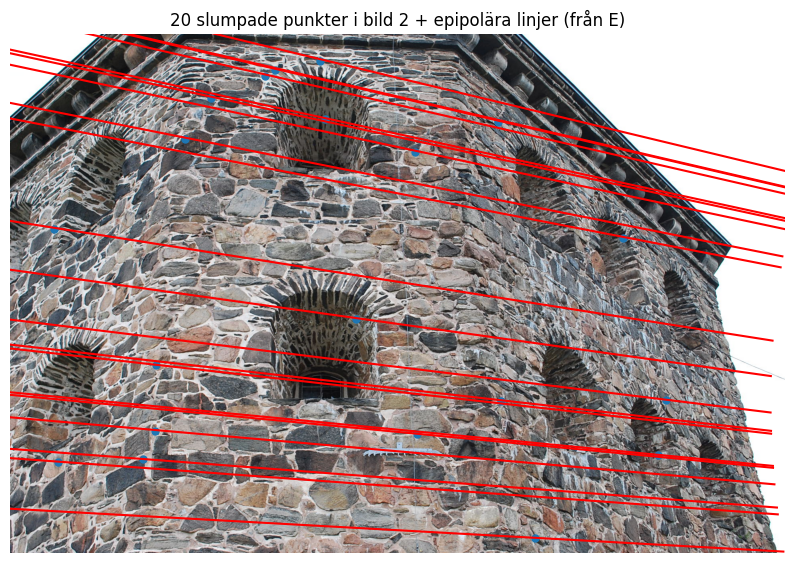

mean distance: 2.083753202690686


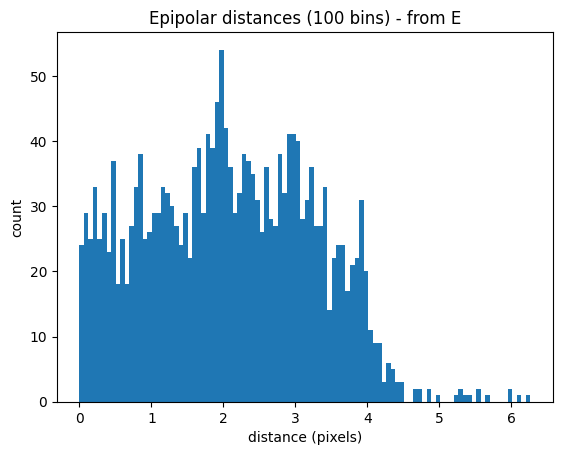

In [50]:
# ------ Your code here ------

# Compute the fundamental matrix from the essential matrix and compute the epipolar lines
F = convert_E_to_F(E, K1, K2)
F = F / np.linalg.norm(F)

l2 = F @ x1
# Plot 20 of the detected points and corresponding epipolar lines in the same figure as the image
rng = np.random.default_rng(0)
N = x2.shape[1]
idx = rng.choice(N, size=min(20, N), replace=False)

I2 = plt.imread("data/kronan2.JPG")

plt.figure(figsize=(10, 7))
plt.imshow(I2)

x_plot = x2[0, idx] / x2[2, idx]
y_plot = x2[1, idx] / x2[2, idx]
plt.scatter(x_plot, y_plot, s=25)

rital(l2[:, idx].T, 'r')

plt.title("20 slumpade punkter i bild 2 + epipolära linjer (från E)")
plt.axis("off")
plt.show()

# Compute the distance between the points and their corresponding epipolar lines and plots these in a histogram
l2_all = F @ x1
x = x2[0, :] / x2[2, :]
y = x2[1, :] / x2[2, :]

a = l2_all[0, :]
b = l2_all[1, :]
c = l2_all[2, :]

dists = np.abs(a*x + b*y + c) / np.sqrt(a*a + b*b)
mean_dist = np.mean(dists)

print("mean distance:", mean_dist)

plt.figure()
plt.hist(dists, bins=100)
plt.title("Epipolar distances (100 bins) - from E")
plt.xlabel("distance (pixels)")
plt.ylabel("count")
plt.show()


### Your answer here: 

(*Include an answer to the question marked in bold.*)
#
Comparison:
In Computer Exercise 2 (E --> F) I got a mean distance of about 2.08 pixels.
This is much higher than in Computer Exercise 1 where I got about 0.36 pixels (with normalization) and about 0.49 pixels .
This makes sense because the essential matrix has stronger constraints and with noisy correspondences enforcing these constraints can increase the pixel residuals when converting E to F.


#### *Theoretical exercise 7* (see pdf)

## Computer Exercise 3


### Task 3.1

\begin{equation}
P_2 = [UWV^T \ u_3] \text{ or } [UWV^T \ -u_3]  \text{ or }
[UW^TV^T \ u_3]  \text{ or } [ UW^TV^T \ -u_3 ]
\end{equation}


For the essential matrix obtained in Computer Exercise 2 compute the four camera solutions above (make sure that `det(U*V') > 0`; otherwise set `V = -V`).

Write a function that does this for you, it will also be useful in the future. The output `P` should contain all four solutions.

In [56]:
def extract_P_from_E(E):
     '''
    A function that extract the four P2 solutions given above
    E - Essential matrix (3x3)
    P - Array containing all four P2 solutions (4x3x4) (i.e. P[i,:,:] is the ith solution) 
    '''
    # Your code here
     U, S, Vt = np.linalg.svd(E)

     if np.linalg.det(U @ Vt) < 0:
        Vt = -Vt

     W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]], dtype=float)

     u3 = U[:, 2].reshape(3, 1)

     R1 = U @ W @ Vt
     R2 = U @ W.T @ Vt

     P = np.zeros((4, 3, 4))

     P[0, :, :] = np.hstack((R1,  u3))
     P[1, :, :] = np.hstack((R1, -u3))
     P[2, :, :] = np.hstack((R2,  u3))
     P[3, :, :] = np.hstack((R2, -u3))

     return P

In [57]:
# ------ Your code here ------

# Extract P2 from E 
P = extract_P_from_E(E)

print("P shape:", P.shape) 

P shape: (4, 3, 4)


Triangulate the points using DLT for each of the four camera solutions, and determine for which of the solutions the points are in front of the cameras.
In this exercise, you may expect to have only one solution for which all the 3D points are in front of both cameras. But in general, since there is noise involved it might not be possible to find a solution with all points in front of the cameras. (In that case the solution with the highest number of points in front of the cameras needs to be selected.)

In [61]:
# ------ Your code here ------

# Triangulate the points using DLT for each of the four camera solutions
import numpy as np

def triangulate_DLT(P1, P2, x1s, x2s):
    N = x1s.shape[1]
    X = np.zeros((4, N))

    for i in range(N):
        x1 = x1s[:, i] / x1s[2, i]
        x2 = x2s[:, i] / x2s[2, i]

        u1, v1 = x1[0], x1[1]
        u2, v2 = x2[0], x2[1]

        A = np.zeros((4, 4))
        A[0, :] = u1 * P1[2, :] - P1[0, :]
        A[1, :] = v1 * P1[2, :] - P1[1, :]
        A[2, :] = u2 * P2[2, :] - P2[0, :]
        A[3, :] = v2 * P2[2, :] - P2[1, :]

        _, _, Vt = np.linalg.svd(A)
        Xi = Vt[-1, :]
        X[:, i] = Xi / Xi[-1]

    return X


# Determine for which of the solutions the points are in front of the cameras
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # [I | 0]

counts = np.zeros(4, dtype=int)
Xs = []

for i in range(4):
    P2 = P[i, :, :]
    X = triangulate_DLT(P1, P2, x1c, x2c)
    Xs.append(X)

    X3 = X[:3, :]
    R = P2[:, :3]
    t = P2[:, 3].reshape(3, 1)

    z1 = X3[2, :]
    z2 = (R @ X3 + t)[2, :]

    counts[i] = np.sum((z1 > 0) & (z2 > 0))

best_i = int(np.argmax(counts))
P2_best = P[best_i, :, :]
X_best = Xs[best_i]

print("points in front for each solution:", counts)
print("best solution index:", best_i)
print("best count:", counts[best_i])

points in front for each solution: [   0 2008    0    0]
best solution index: 1
best count: 2008


Compute the corresponding camera matrices for the original (un-normalized) coordinate system and plot the image points and the projected 3D-points in the same figure.
**Do the errors look small?**
Verify that the projections are reasonably well aligned with the image points.

Reprojection error img1: mean = 0.989156200314922 RMS = 1.1369160225115362 max = 2.9520175045713413
Reprojection error img2: mean = 1.0411589395329313 RMS = 1.1927312233931244 max = 3.1310618723729307


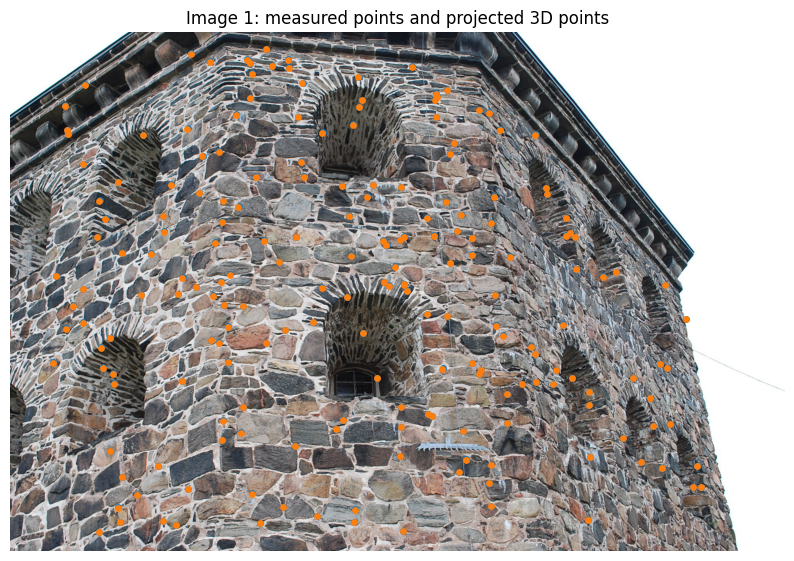

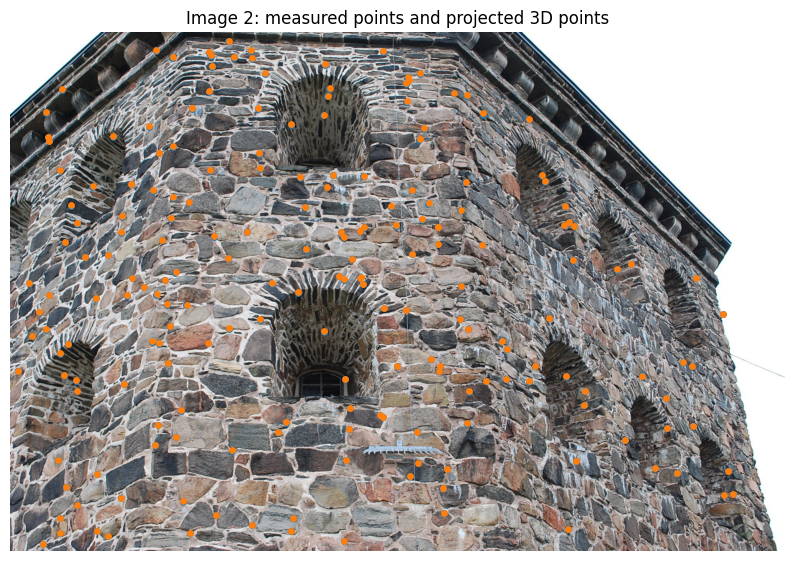

In [64]:
# ------ Your code here ------
import numpy as np
import matplotlib.pyplot as plt

# Compute the corresponding camera matrices for the original (un-normalized) coordinate system

P1_norm = np.hstack((np.eye(3), np.zeros((3, 1))))
P2_norm = P2_best

P1_pix = K1 @ P1_norm
P2_pix = K2 @ P2_norm

def project(P, X):
    x = P @ X
    x = x / x[2, :]
    return x

x1_proj = project(P1_pix, X_best)
x2_proj = project(P2_pix, X_best)

x1_inh = x1 / x1[2, :]
x2_inh = x2 / x2[2, :]

e1 = np.sqrt((x1_inh[0, :] - x1_proj[0, :])**2 + (x1_inh[1, :] - x1_proj[1, :])**2)
e2 = np.sqrt((x2_inh[0, :] - x2_proj[0, :])**2 + (x2_inh[1, :] - x2_proj[1, :])**2)

print("Reprojection error img1: mean =", np.mean(e1), "RMS =", np.sqrt(np.mean(e1**2)), "max =", np.max(e1))
print("Reprojection error img2: mean =", np.mean(e2), "RMS =", np.sqrt(np.mean(e2**2)), "max =", np.max(e2))


# Plot the image points and the projected 3D-points in the same figure

rng = np.random.default_rng(0)
N = x1.shape[1]
idx = rng.choice(N, size=min(200, N), replace=False)

I1 = plt.imread("data/kronan1.JPG")
I2 = plt.imread("data/kronan2.JPG")

plt.figure(figsize=(10, 7))
plt.imshow(I1)
plt.scatter(x1_inh[0, idx], x1_inh[1, idx], s=15)
plt.scatter(x1_proj[0, idx], x1_proj[1, idx], s=15)
plt.title("Image 1: measured points and projected 3D points")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(I2)
plt.scatter(x2_inh[0, idx], x2_inh[1, idx], s=15)
plt.scatter(x2_proj[0, idx], x2_proj[1, idx], s=15)
plt.title("Image 2: measured points and projected 3D points")
plt.axis("off")
plt.show()

Plot the 3D points and camera centers and principal axes in a 3D plot.
**Does it look like you expected it to ?**

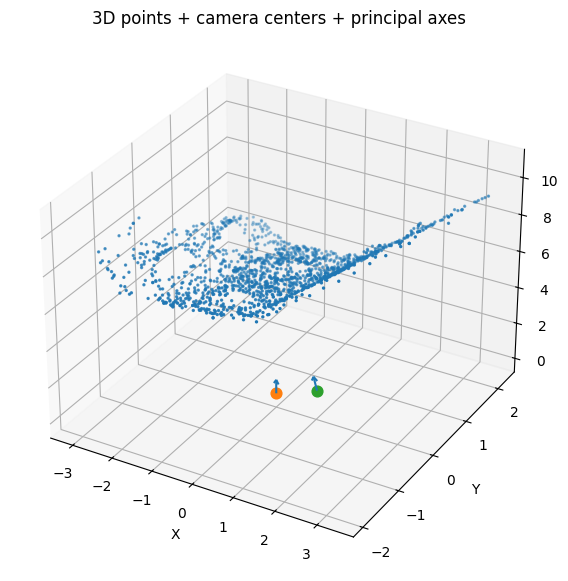

In [66]:
# ------ Your code here ------

# Plot the 3D points and camera centers and principal axes in a 3D plot 
import numpy as np
import matplotlib.pyplot as plt

def camera_center(P):
    R = P[:, :3]
    t = P[:, 3]
    C = -np.linalg.inv(R) @ t
    return C

def principal_axis(P):
    R = P[:, :3]
    a = R.T @ np.array([0.0, 0.0, 1.0])
    return a / np.linalg.norm(a)

X = X_best[:3, :]

C1 = camera_center(P1_norm)
C2 = camera_center(P2_best)

a1 = principal_axis(P1_norm)
a2 = principal_axis(P2_best)

scale = 0.5 * np.median(np.linalg.norm(X - X.mean(axis=1, keepdims=True), axis=0))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

rng = np.random.default_rng(0)
idx = rng.choice(X.shape[1], size=min(1500, X.shape[1]), replace=False)
ax.scatter(X[0, idx], X[1, idx], X[2, idx], s=2)

ax.scatter([C1[0]], [C1[1]], [C1[2]], s=60, marker='o')
ax.scatter([C2[0]], [C2[1]], [C2[2]], s=60, marker='o')

ax.quiver(C1[0], C1[1], C1[2], a1[0], a1[1], a1[2], length=scale)
ax.quiver(C2[0], C2[1], C2[2], a2[0], a2[1], a2[2], length=scale)

ax.set_title("3D points + camera centers + principal axes")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

### Your answer here: 

(*Include an answer to the question marked in bold.*)
#

Yes. The reprojection errors are around ~1 pixel on average, which is small and indicates good alignment. For image 1 I got mean ≈ 0.99 px (RMS ≈ 1.14 px, max ≈ 2.95 px) and for image 2 mean ≈ 1.04 px (RMS ≈ 1.19 px, max ≈ 3.13 px). The projected 3D points also look reasonably well aligned with the measured image points in both images.

Yes. When We triangulated using the four P2 solutions, only one solution gave points in front of both cameras: counts = [0, 2008, 0, 0], so I selected solution index 1. In the 3D plot the two camera centers are separated by a small baseline, the principal axes point towards the reconstructed point cloud, and the points lie in front of the cameras. The point cloud is also somewhat stretched in depth, which is expected with a small baseline and noisy correspondences (depth becomes less accurate further away).